# Post processing notebook for darknet chipping detections
1. Detections are saved to one or multiple pkl files if there are many so we need to consolidate them
2. Filter by confidence then NMS.  NMS is run during detection generally but since we detect with overlapping chips there are often duplicates and because of multithreading we don't deal with those during detection.
3. Seperate new detections that are not in database from ones that are in database by IoU

In [1]:
import cv2
PKL_FILE_BASE_NAME = "/fast/experiments/yolov4_3c_832/base/inference/kotz/kotz_fl01_fl04_fl05_detections.pkl"

In [2]:
import os
import pickle
import sys
import numpy as np
sys.path.append("/home/yuval/Documents/XNOR/sealnet/models/darknet")
import matplotlib.pyplot as plt
from pydn.inference.nms import non_max_suppression_fast
from pydn.inference.util import save_dets, get_matches_api, load
from IPython.display import Image

In [3]:
# function definitions
def append_to_base(fp, add):
    base, ext = os.path.splitext(fp)
    base = base+add+ext
    return base

# consolidate detections from multiple pkl files
def consolidated_detections(pkl_files):
    detections = {}
    for pkl_file in pkl_files:
        if os.path.isfile(pkl_file):
            with open(pkl_file, "rb") as f:
                r = pickle.load(f)
                for k in r:
                    if k not in detections:
                        detections[k] = r[k]
    return detections

def det_count(dets):
    print("Count %d" % sum([len(value) for key, value in dets.items()]))
    


def filter_dets(detections, nms_thresh):
    print("NMS %.2f" % (nms_thresh))
    new_dets = {}
    for im in detections:
        dets = detections[im]
        boxes = []
        for det in dets:
            boxes.append(np.array(det.box))
        boxes_pre = np.array(boxes)
        pick = non_max_suppression_fast(boxes_pre, nms_thresh)
        det_list = np.array(dets)
        new_det_list = det_list[pick]
        new_dets[im] = new_det_list
    return new_dets

## Consolidate detections from multiple pickle files

In [4]:
pkl_file_out_consolidate = append_to_base(PKL_FILE_BASE_NAME, '_consolidated')
pkl_file_out_consolidate

'/fast/experiments/yolov4_3c_832/base/inference/kotz/kotz_fl01_fl04_fl05_detections_consolidated.pkl'

In [5]:
%%script false  --no-raise-error
# === Consolidate
pkl_files= ['/fast/experiments/yolov4_3c_832/base/inference/kotz/kotz_fl01_fl04_fl05_detections_2.pkl',
            '/fast/experiments/yolov4_3c_832/base/inference/kotz/kotz_fl01_fl04_fl05_detections.pkl']

dets = consolidated_detections(pkl_files)
save_dets(pkl_file_out_consolidate,dets)


## Filter overlapping duplicated by confidence and then run nms
We do this because we detected with lots of overlap so we want to get rid of duplicate detections caused by overlap

In [9]:
# nms = .2
# conf = .5
nms=.2
conf = .1
pkl_file_out_filter = append_to_base(pkl_file_out_consolidate, '_nms%.2f_conf%.2f' % (nms,conf))
pkl_file_out_filter

'/fast/experiments/yolov4_3c_832/base/inference/kotz/kotz_fl01_fl04_fl05_detections_consolidated_nms0.20_conf0.10.pkl'

In [10]:
%%script false --no-raise-error
detections = load(pkl_file_out_consolidate)
if detections is None:
    raise Exception("Error loading %s" % pkl_file_out_consolidate)


In [11]:
%%script false --no-raise-error
det_count(detections)
conf_dets = filter_confidence(detections,conf)
new_dets = filter_dets(conf_dets, nms)
det_count(new_dets)

save_dets(pkl_file_out_filter,new_dets)

In [12]:
pkl_file_new = append_to_base(pkl_file_out_filter,"_new")
pkl_file_matched = append_to_base(pkl_file_out_filter,"_matched")
pkl_file_matched_fp = append_to_base(pkl_file_out_filter,"_matched_fp")
(pkl_file_new, pkl_file_matched,pkl_file_matched_fp)

('/fast/experiments/yolov4_3c_832/base/inference/kotz/kotz_fl01_fl04_fl05_detections_consolidated_nms0.20_conf0.10_new.pkl',
 '/fast/experiments/yolov4_3c_832/base/inference/kotz/kotz_fl01_fl04_fl05_detections_consolidated_nms0.20_conf0.10_matched.pkl',
 '/fast/experiments/yolov4_3c_832/base/inference/kotz/kotz_fl01_fl04_fl05_detections_consolidated_nms0.20_conf0.10_matched_fp.pkl')

In [ ]:
# %%script false  --no-raise-error
detections = load(pkl_file_out_filter)

if detections is None:
    raise Exception("Error loading %s" % pkl_file_out_filter)

matched_dets = {}
new_dets = {}
fp_matches = {}
for img, dets in detections.items():
    if len(dets) == 0:
        continue
    
    img_basename = os.path.basename(img)
    boxes = []
    for det in dets:
        box = det.box
        boxes.append({"x1": int(box[0]),"y1": int(box[1]),"x2": int(box[2]),"y2": int(box[3]), 
                      "confidence": float(det.confidence)})

    matches = get_matches_api(boxes, img_basename)
    for det, match in zip(dets,matches):
        if match is None or match['iou'] < .2:
            if not img in new_dets:
                new_dets[img] = []
            new_dets[img].append(det)
        elif match['species']['name'] == 'false positive':
            if not img in fp_matches:
                fp_matches[img] = [] 
            fp_matches[img].append({'det': det, 'species':match['species'], 'label':match['match'], 'iou':match['iou']})
        else:
            if not img in matched_dets:
                matched_dets[img] = []
            matched_dets[img].append({'det': det, 'species':match['species'], 'label':match['match'], 'iou':match['iou']})
            
print("Saving new detections")
det_count(new_dets)
save_dets(pkl_file_new,new_dets)
print("Saving matched detections")
det_count(matched_dets)
save_dets(pkl_file_matched,matched_dets)
print("Saving matched fp detections")
det_count(fp_matches)
save_dets(pkl_file_matched_fp,fp_matches)

In [ ]:
new_dets = load(pkl_file_new)

In [ ]:
# Visualize confidence

In [ ]:
# Visualize confidence

In [ ]:
# Visualize confidence

# Visualize confidence

In [ ]:
import scipy.stats as st
import seaborn as sns
# load matched and unique
new_dets = load(pkl_file_new)
matched_dets = load(pkl_file_matched)
fp_matches = load(pkl_file_matched_fp)

### Visualize true positive match confidences vs false positive match confidences

In [11]:
tp_ious = []
tp_confidences = []
for im in matched_dets:
    matches = matched_dets[im]
    for match in matches:
        conf = match['det'].confidence
        iou = match['iou']
        tp_confidences.append(conf)
        tp_ious.append(iou)

fp_ious = []
fp_confidences = []
for im in fp_matches:
    matches = fp_matches[im]
    for match in matches:
        conf = match['det'].confidence
        iou = match['iou']
        fp_confidences.append(conf)
        fp_ious.append(iou)

fp_ious = np.array(fp_ious)   
fp_confidences = np.array(fp_confidences)
tp_ious = np.array(tp_ious)   
tp_confidences = np.array(tp_confidences)

/home/yuval/anaconda3/envs/sealnet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


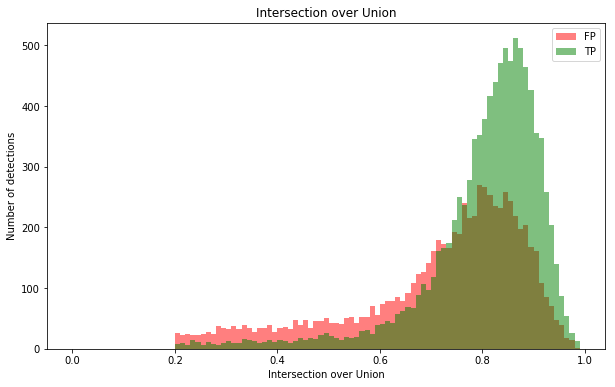

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bins=np.arange(0,1.0,.01)
ax.hist(fp_ious, bins, alpha=0.5,normed=0, label='FP', color='red')
ax.hist(tp_ious, bins, alpha=0.5, normed=0,label='TP', color='green')
ax.legend(loc='upper right')
plt.xlabel("Intersection over Union")
plt.ylabel("Number of detections")
plt.title("Intersection over Union")
plt.show()

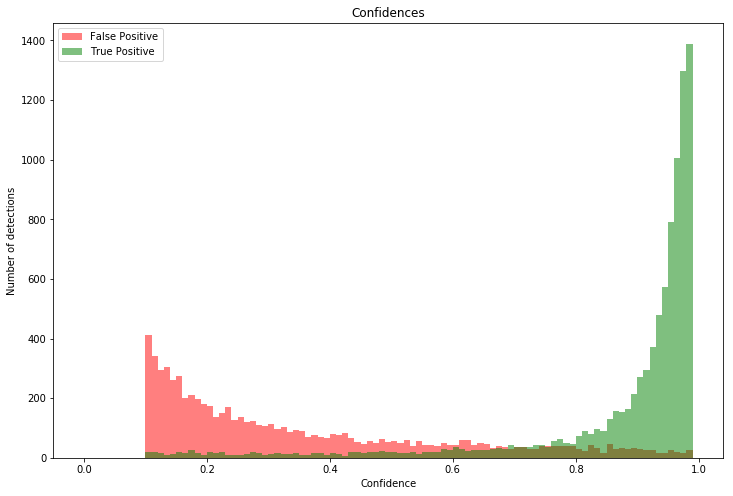

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
bins=np.arange(0,1.0,.01)
ax.hist(fp_confidences, bins, alpha=0.5,normed=0, label='False Positive', color='red')
ax.hist(tp_confidences, bins, alpha=0.5, normed=0,label='True Positive', color='green')
ax.legend(loc='upper left')
plt.title("Confidences")
plt.xlabel("Confidence")
plt.ylabel("Number of detections")
plt.show()


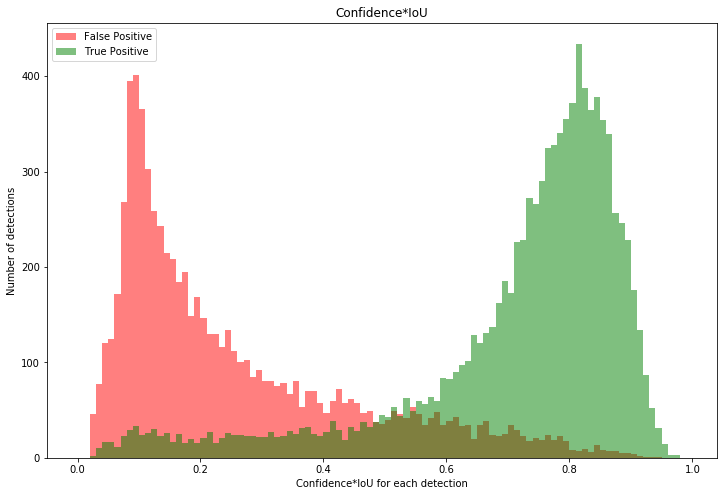

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
bins=np.arange(0,1.0,.01)
fp_ic = fp_ious*fp_confidences
tp_ic = tp_ious*tp_confidences
ax.hist(fp_ic, bins, alpha=0.5,normed=0, label='False Positive', color='red')
ax.hist(tp_ic, bins, alpha=0.5, normed=0,label='True Positive', color='green')
ax.legend(loc='upper left')
plt.title("Confidence*IoU")
plt.xlabel("Confidence*IoU for each detection")
plt.ylabel("Number of detections")
plt.show()


### Visualize new detections confidence counts 

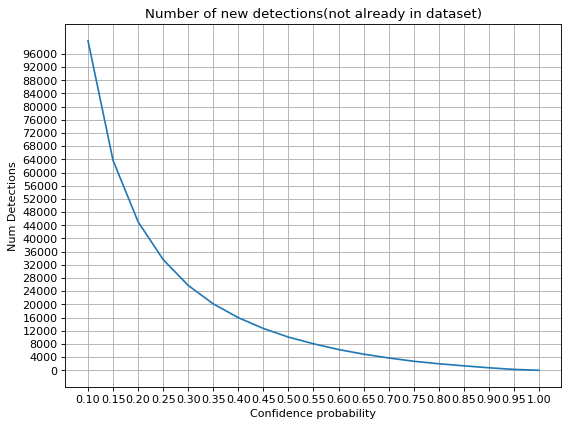

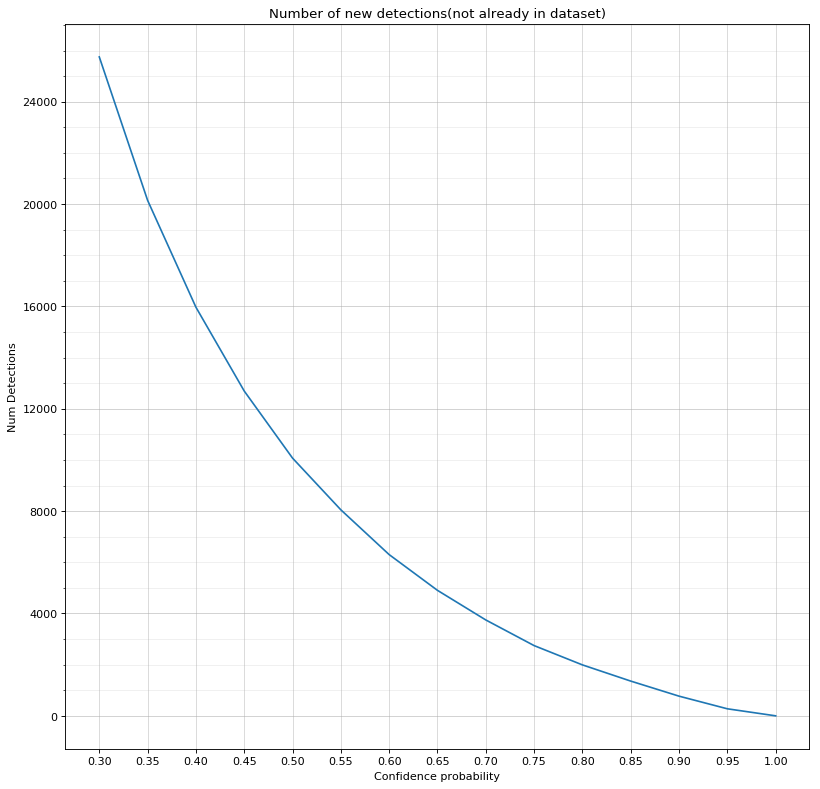

In [15]:
x = np.arange(start=.1, stop=1.05, step=.05)
new_count = np.zeros(len(x))
for i,conf in enumerate(x):
    for j, im in enumerate(new_dets):
        dets = new_dets[im]
        for det in dets:
            if det.confidence > conf:
                new_count[i]+=1
          
fig = plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.xticks(x)
plt.yticks(np.arange(start=np.min(new_count), stop=np.max(new_count), step=4000))
plt.grid()
plt.xlabel("Confidence probability")
plt.ylabel("Num Detections")
plt.title("Number of new detections(not already in dataset)")
plt.plot(x, new_count)

fig = plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
minor_ticks = np.arange(start=np.min(new_count), stop=np.max(new_count), step=1000)
major_ticks = np.arange(start=np.min(new_count), stop=np.max(new_count), step=4000)

ax.set_xticks(x[4:])
# ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.xlabel("Confidence probability")
plt.ylabel("Num Detections")
plt.title("Number of new detections(not already in dataset)")
plt.plot(x[4:], new_count[4:])
            

## Visualize unique detections

In [17]:
%gui qt
from skimage import data
import napari
classes=["Ringed Seal","Bearded Seal","Polar Bear"]
new_dets = filter_confidence(new_dets,.7)
image_fns = list(new_dets)
global idx
idx = 0
viewer = napari.Viewer()
images = []
for image in image_fns[:50]:
    image_fn = image
    original = cv2.imread(image_fn)
    images.append((image_fn,original))
def next():
    while len(viewer.layers) > 0:
        viewer.layers.pop(0)
    fn, original = images.pop()
    rects = []
    rects_matched = []
    rects_fp = []
    annotations = []
    points = []
    for det in new_dets[fn]:
        box = det.box
        rects.append([[box[1], box[0]], [box[3], box[2]]])
#         annotations.append(classes[det.classid] + ' %.3f' % det.confidence)
#         points.append((box[0], box[1] - 13))
    if fn in matched_dets:
        for det in matched_dets[fn]:
            label = det['label']
            rects_matched.append([[label['y1'], label['x1']], [label['y2'], label['x2']]])
    if fn in fp_matches:
        for det in fp_matches[fn]:
            label = det['label']
            rects_fp.append([[label['y1'], label['x1']], [label['y2'], label['x2']]])
#      
        
    viewer.add_image(original, name=fn)
    viewer.add_shapes(rects, shape_type='rectangle', edge_width=5,
                              edge_color='magenta', face_color='transparent')
    viewer.add_shapes(rects_matched, shape_type='rectangle', edge_width=5,
                          edge_color='green', face_color='transparent')
    viewer.add_shapes(rects_fp, shape_type='rectangle', edge_width=5,
                          edge_color='red', face_color='transparent')

@viewer.bind_key('p')
def print_names(viewer):
    next()
    
#viewer.add_text(points, text=annotations, font_size=font_size)

Confidence 0.70


NameError: name 'cv2' is not defined